# Question 1 - Discounts

## Define Question

Northwind is a company that connects suppliers with consumers across the globe. Discounts of various levels are occasionally offered on products. The goal of these discounts is to increase the quantity of products ordered. In this document, I explore whether that theory holds true.

> Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?

## State Hypothesis

**Null Hypothesis**: Discount has no effect on the average quantity ordered. 

> $H_{o}: \mu_1 = \mu_2$ 

**Alternative Hypothesis**: Discount has a statistically significant effect on the average quantity ordered.

> $H_{a}: \mu_1 < \mu_2$ 

**Significance Level**: 95% confidence level

> $\alpha = .05$

## Methodology


First, I compare the means of the quantities purchased with and without discounts. Then I compare the means of the quantities purchased with the major levels of discount.

I use resampling to create a **sampling distribution** to satisfy the normality assumption of the major hypothesis tests. I run a **one-tailed Welch's T-Test** to compare the means of the two groups. Finally, I use an **ANOVA test** and a **Tukey Test** to compare the levels of discount. I then explain my results and recommendations.

## Import Libraries and Connect to Data

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
import seaborn as sns
import scipy.stats as stats
from hypothesis_testing import bootstrap, create_sampling_distribution, remove_outliers, Cohen_d
import warnings
warnings.filterwarnings('ignore')
import itertools

In [2]:
#Connect to server and create cursor
conn = sqlite3.connect('northwind_small.sqlite')
c = conn.cursor()

## Obtain Data

First I familiarize myself with the summary statistics for the different discount levels. 

In [3]:
query = """SELECT Discount, 
                  avg(Quantity) AS AverageQuantity,
                  count(*) AS TotalOrders,
                  ((od.Quantity*od.UnitPrice)*(1-od.Discount)) as GrossRevenue
           FROM OrderDetail od
           GROUP BY Discount
           """
pd.read_sql(query,conn)

,Discount,AverageQuantity,TotalOrders,GrossRevenue
0,0.00,21.715262,1317,26.000
1,0.01,2.000000,1,29.700
2,0.02,2.000000,2,35.280
3,0.03,1.666667,3,64.505
4,0.04,1.000000,1,77.760
5,0.05,28.010811,185,34.200
6,0.06,2.000000,1,63.920
7,0.10,25.236994,173,72.000
8,0.15,28.382166,157,30.600
9,0.20,27.024845,161,364.800


Some levels of discount lack adequate data for analysis. I focus my analysis on discounts with 100 or more total orders. 

Columns of interest: Quantity, Discount

Dataframes required:
* new_df = sales with outliers removed from Quantity
* no_discount_df = sales without discounts
* has_discount_df = sales with discounts

In [4]:
# Dataframe all_df of all sales
query = """SELECT od.Quantity, od.Discount,
            ((od.Quantity*od.UnitPrice)*(1-od.Discount)) as GrossRevenue
            FROM OrderDetail od
            WHERE od.Discount IN (0, 0.05, 0.10, 0.15, 0.20, 0.25);"""
all_df = pd.read_sql(query, conn)
display(all_df.head())
all_df.describe()

,Quantity,Discount,GrossRevenue
0,12,0.0,168.0
1,10,0.0,98.0
2,5,0.0,174.0
3,9,0.0,167.4
4,40,0.0,1696.0


,Quantity,Discount,GrossRevenue
count,2147.000000,2147.000000,2147.000000
mean,23.895203,0.056265,589.399613
std,19.009580,0.083586,970.459342
min,1.000000,0.000000,4.800000
25%,10.000000,0.000000,148.671250
50%,20.000000,0.000000,340.000000
75%,30.000000,0.100000,660.000000
max,130.000000,0.250000,15810.000000


## Scrub Data

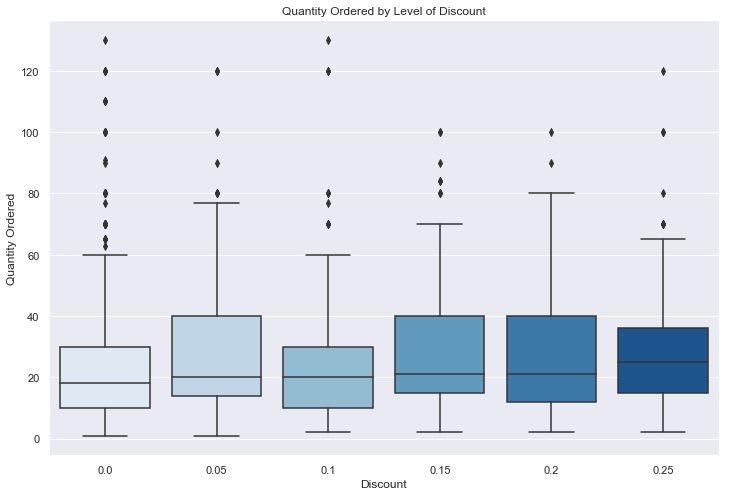

In [19]:
# Visualize data by discount level with boxplots
sns.set(rc={'figure.figsize':(12,8)})
sns.boxplot(x='Discount', y='Quantity', 
            data=all_df, palette='Blues')
plt.title('Quantity Ordered by Level of Discount')
plt.xlabel('Discount');
plt.ylabel('Quantity Ordered')
plt.show()

Some discount levels have clear outliers. I remove the outliers before splitting my dataframe into my control group and experiment group. 

In [6]:
# Remove outliers
new_df = remove_outliers(all_df, 'Quantity')
print('Number of outliers removed: ', 
        all_df.shape[0] - new_df.shape[0])

Number of outliers removed:  77


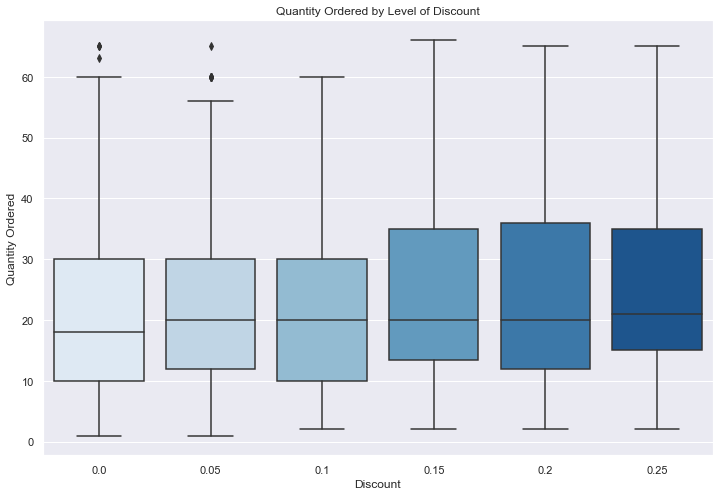

In [20]:
# Visualize data by discount level without outliers with boxplots
sns.set(rc={'figure.figsize':(12,8)})
sns.boxplot(x='Discount', y='Quantity', 
            data=new_df, palette='Blues')
plt.title('Quantity Ordered by Level of Discount')
plt.xlabel('Discount');
plt.ylabel('Quantity Ordered')
plt.show()

## Create Control and Experiment Groups

Much better! Now I split my dataframe into the desired groups. 

* control group = without discount
* experimental group = with discount

In [8]:
# Create control and experimental groups
no_discount_df = new_df.loc[(new_df['Discount'] == 0)]
has_discount_df = new_df.loc[(new_df['Discount'] != 0)]

In [9]:
# Check size of dataframes
display(no_discount_df.shape, has_discount_df.shape)

(1287, 3)

(783, 3)

## Hypothesis Testing

As a reminder: 

**Null Hypothesis**: Discount has no effect on the average quantity ordered. 

> $H_{o}: \mu_1 = \mu_2$ 

**Alternative Hypothesis**: Discount has a statistically significant effect on the average quantity ordered.

> $H_{a}: \mu_1 < \mu_2$ 

**Significance Level**: 95% confidence level

> $\alpha = .05$

I perform a T-Test to compare the means of the two groups. I believe that applying a discount will increase the mean quantity ordered rather than decrease it. Thus I perform a **one-tailed T-Test**. 

First I must satisfy the **normality assumption** for the test. 

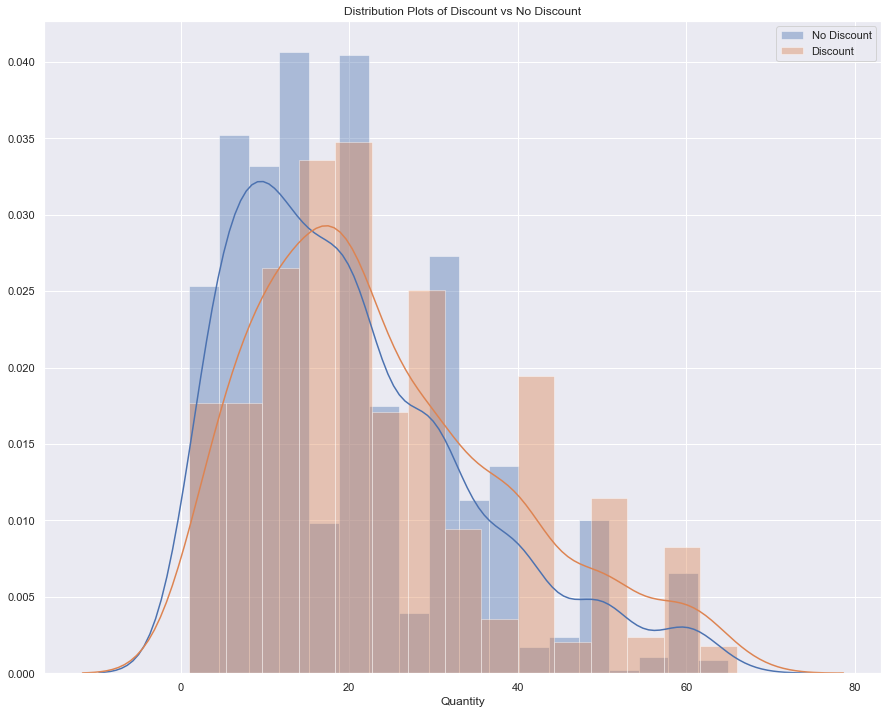

In [10]:
# Visualize distribution of two groups
sns.distplot(no_discount_df['Quantity'], 
             label='No Discount')
sns.distplot(has_discount_df['Quantity'], 
             label='Discount')
plt.title('Distribution Plots of Discount vs No Discount')
plt.legend();

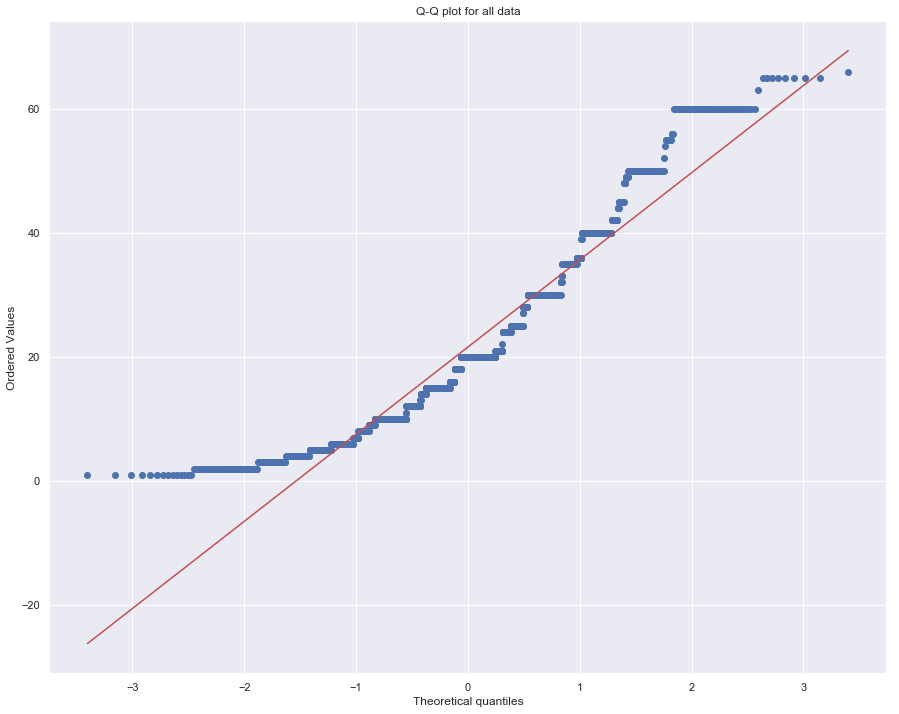

In [11]:
# Check normality
stats.probplot(new_df.Quantity, dist="norm", plot=plt)
plt.title("Q-Q plot for all data")
plt.show()

The data does not meet the normality assumption. I take a **sampling distribution** of sample means for each of the two groups. According to the **Central Limit Theorem**, the distribution of sample means is approximately normally distributed. 

In [12]:
no_d_samp = create_sampling_distribution(no_discount_df['Quantity'], 150, 30)
has_d_samp = create_sampling_distribution(has_discount_df['Quantity'], 150, 30)


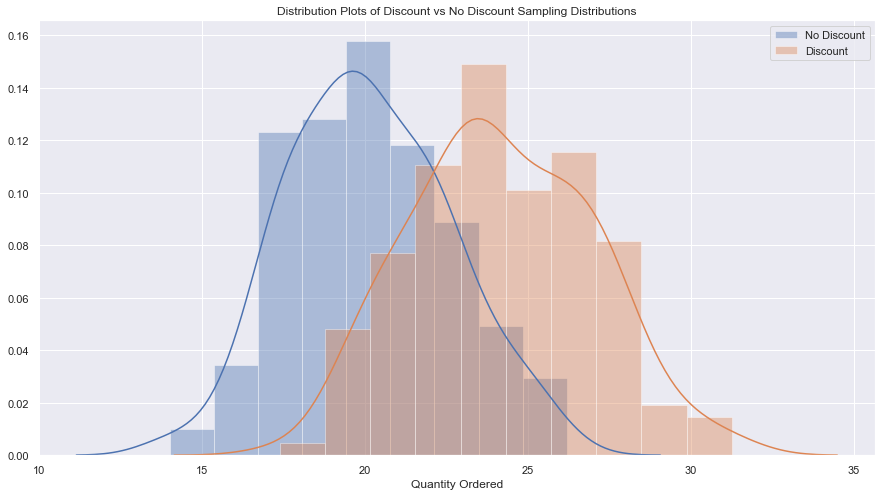

In [13]:
# Check normality assumption for sampling distributions
plt.figure(figsize=(15,8))
plt.title('Distribution Plots of Discount vs No Discount Sampling Distributions')
sns.distplot(no_d_samp, label='No Discount')
sns.distplot(has_d_samp, label='Discount')
plt.xlabel('Quantity Ordered')
plt.legend();


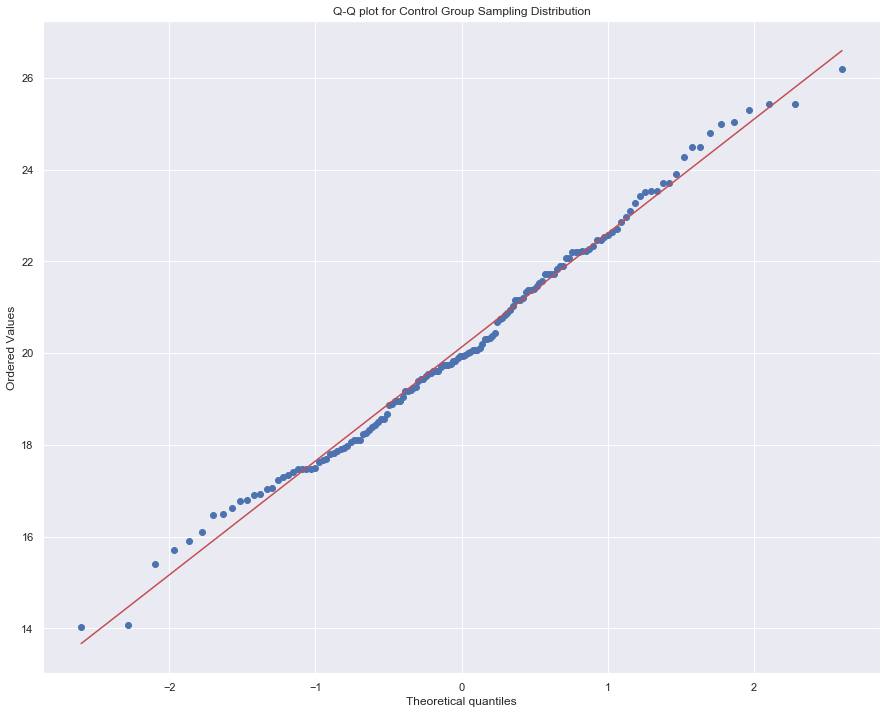

In [14]:
# QQ Plot for control group sampling distribution
stats.probplot(no_d_samp, dist="norm", plot=plt)
plt.title("Q-Q plot for Control Group Sampling Distribution")
plt.show()

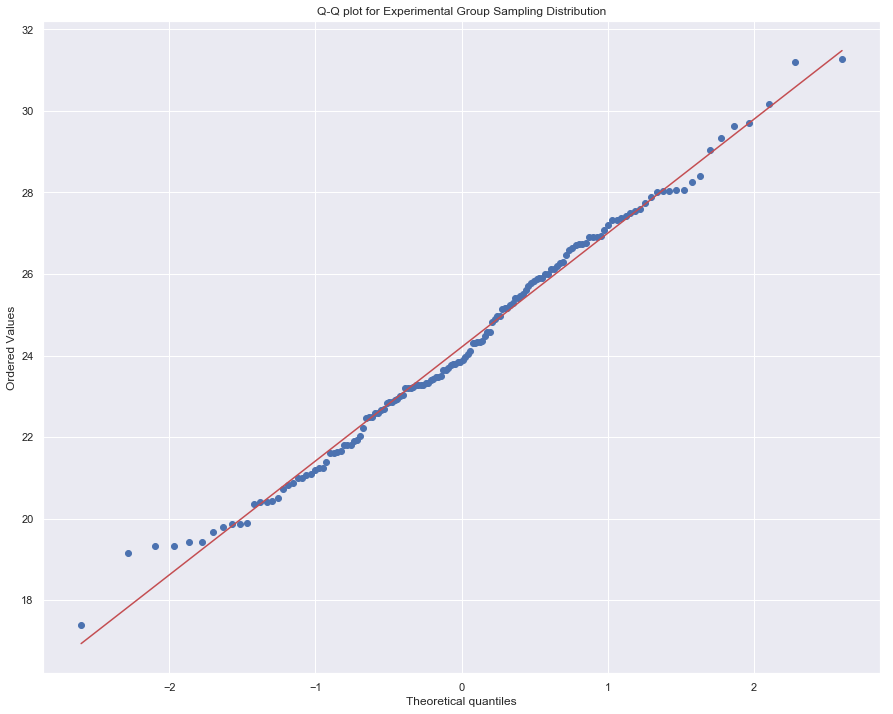

In [15]:
# QQ Plot for experimental group sampling distribution
stats.probplot(has_d_samp, dist="norm", plot=plt)
plt.title("Q-Q plot for Experimental Group Sampling Distribution")
plt.show()

The two groups now satisfy the normality assumption for T-Tests. I could run a Student T-Test or a Welch's T-Test depending on if the variances of the two groups are equal. 

In [16]:
np.var(no_d_samp) == np.var(has_d_samp)

False

The variances of the two groups are not equal. I use a **Welch's T-Test** to test my hypothesis.

In [21]:
# Welch's T-Test
stat, pval = stats.ttest_ind(no_d_samp, 
                has_d_samp, 
                equal_var=False)
print("Welch's T-Test \nP-value: {} \nReject Null Hypothesis: {}"
     .format(pval, pval<0.05))

Welch's T-Test 
P-value: 1.689251598956542e-32 
Reject Null Hypothesis: True


I reject my null hypothesis. 

## Effect Size

In [22]:
a, b = np.array(no_discount_df), np.array(has_discount_df)
Cohen_d(a,b)

0.019189414525390698

Cohen's d values under 0.2 indicate a small effect size.

## Compare Discount Rates

In [40]:
discount_rates = [0, .05, .1, .15, .2, .25]
discount_combinations = itertools.combinations(discount_rates, 2)

In [41]:
# T-test for quantity average sales revenue per order from each region
discount_rates_combo_df = pd.DataFrame(columns = ['Discount 1','Discount 2','p-value',
                                                      'Reject Null?', 'Discount 1 Revenue Mean', 'Discount 2 Revenue Mean',
                                                      'Difference of Means', 'Cohens d'])

for combo in discount_combinations:
    
    samp1_control = new_df[new_df['Discount']==combo[0]]['Quantity']
    samp2_experimental = new_df[new_df['Discount']==combo[1]]['Quantity']
    
    s1mean = new_df[new_df['Discount']==combo[0]]['Quantity'].mean()
    s2mean = new_df[new_df['Discount']==combo[1]]['Quantity'].mean()
    
    t_stat, p_val = stats.ttest_ind(samp1_control, samp2_experimental)
    diff_means = round(samp1_control.mean() - samp2_experimental.mean(),2)
    effect_size_cohen = round(Cohen_d(samp1_control, samp2_experimental),3)
    
    p_val = p_val / 2 # for one tailed test
    
    discount_rates_combo_df = discount_rates_combo_df.append({'Discount 1' : combo[0], 'Discount 2': combo[1], 
                                                 'p-value': p_val, 'Reject Null?': "Yes, Reject" if p_val < 0.05 else "No, Fail to Reject",
                                                           'Discount 1 Revenue Mean': s1mean, 'Discount 2 Revenue Mean': s2mean,
                                                 'Difference of Means': diff_means, 'Cohens d': effect_size_cohen}, ignore_index=True)

In [42]:
discount_rates_combo_df[discount_rates_combo_df['Reject Null?'] == "Yes, Reject"]


,Discount 1,Discount 2,p-value,Reject Null?,Discount 1 Revenue Mean,Discount 2 Revenue Mean,Difference of Means,Cohens d
0,0,0.05,0.002107,"Yes, Reject",20.156177,23.479532,-3.32,0.233
2,0,0.15,0.000351,"Yes, Reject",20.156177,24.369863,-4.21,0.297
3,0,0.20,0.000046,"Yes, Reject",20.156177,24.909677,-4.75,0.334
4,0,0.25,0.000011,"Yes, Reject",20.156177,25.435374,-5.28,0.372
9,0.1,0.15,0.049719,"Yes, Reject",21.640244,24.369863,-2.73,0.189
10,0.1,0.20,0.024318,"Yes, Reject",21.640244,24.909677,-3.27,0.222
11,0.1,0.25,0.011259,"Yes, Reject",21.640244,25.435374,-3.80,0.261


## Results

Based on the results to hypothesis testing, I conclude that adding a discount to a product has a statistically significant effect on the quantity purchased. The level of discount matters only slightly. Discounts of 10% are not statistically significant, but other levels are. There is no statistical significance in the quantity ordered at discount levels of 5%, 15%, 20%, or 25%.

## Recommendations

I recommend that Northwind offer discounts of 5% as an incentive to increase quantity ordered. Higher discounts do not lead to higher quantities. As a result, discounts higher than 5% would most likely decrease gross revenue. Discounts do have a statistically significant effect on quantity ordered as opposed to no discount. In particular, Northwind should target customers who are not currently receiving a lot of discounts, and begin offering them minor discounts on all products. They should also lower all discount amounts to 5%.